<a href="https://colab.research.google.com/github/anthony-1210/thesis_two_layer_LM/blob/main/two_layer_LM_hdfs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# two layers LM

The architecture of the model are as following:

Note: Log sequence consists of log events

1. For each log sequence, we feed the log events into BERT to get the embeddings of events
2. Adding positional encoding to the events within the sequence
3. Feed log events w/ positional encoding into second layer, which is transformer encoder
4. Retrieve the last hidden state of transformer encoder and stack with SVDD

## GPU info

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Apr 11 16:04:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


## Common

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

In [1]:
from transformers import BertModel, BertConfig, BertTokenizer, BertForMaskedLM, AdamW
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from os import path
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.metrics import (
    confusion_matrix, precision_recall_fscore_support, roc_curve, roc_auc_score
)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import re
import gc
import ast

tqdm.pandas()

In [2]:
print(torch.__version__)

2.2.1+cu121


### Abstractor

In [ ]:
MAX_N_DIGITS = 12

hdfs_rules = {
    "sdf": "(blk_[0-9-]+)", # ID
    "afj": "(\d{1,3}(\.\d{1,3}){3})(:[0-9]{1,5})?", # IP
    "seij": "([a-f0-9]{1}[a-f0-9\\-]{31,39})", # HASH
}

# hdfs_rules = {
#     "ID": "(blk_[0-9-]+)",
#     "IP": "(\d{1,3}(\.\d{1,3}){3})(:[0-9]{1,5})?",
#     "HASH": "([a-f0-9]{1}[a-f0-9\\-]{31,39})",
# }

def get_hdfs_tokenizer(path, replace_num=False):
    tokenizer = BertTokenizer.from_pretrained(path)
    tokens = [f"<{name}>" for name in hdfs_rules]
    if replace_num:
        tokens += ["<elw:over>"]
        tokens += [f"<elw:{i+1}>" for i in range(MAX_N_DIGITS)]
    tokenizer.add_tokens(tokens)
    return tokenizer

# def get_hdfs_tokenizer(path, replace_num=False):
#     tokenizer = BertTokenizer.from_pretrained(path)
#     tokens = [f"<{name}>" for name in hdfs_rules]
#     if replace_num:
#         tokens += ["<NUM:over>"]
#         tokens += [f"<NUM:{i+1}>" for i in range(MAX_N_DIGITS)]
#     tokenizer.add_tokens(tokens)
#     return tokenizer

In [ ]:
def abstract_hdfs(
    text: str,
    noise: str = ",/:._-",
    replace_num: bool = False
) -> str:
    abstract = text.rstrip()
    for name in hdfs_rules:
        abstract = re.sub(hdfs_rules[name], f"<{name}>", abstract)
    if len(noise) > 0:
        abstract = re.sub(f"[{noise}]", " ", abstract)
    if replace_num:
        abstract = abstract_number(abstract)
    return abstract


def abstract_number(text: str) -> str:
    "Convert number string in the text to a token with its length."
    while match := re.search(r'\b\d{3,}[\.]?\d*\b', text):
        i, j = match.span()
        it = match.group().split(".")[0]
        token = None
        if len(it) > MAX_N_DIGITS:
            token = "<elw:over>"
        else:
            token = f"<elw:{len(it)}>"
        text = token.join([text[:i], text[j:]])

    return text

# def abstract_number(text: str) -> str:
#     "Convert number string in the text to a token with its length."
#     while match := re.search(r'\b\d{3,}[\.]?\d*\b', text):
#         i, j = match.span()
#         it = match.group().split(".")[0]
#         token = None
#         if len(it) > MAX_N_DIGITS:
#             token = "<NUM:over>"
#         else:
#             token = f"<NUM:{len(it)}>"
#         text = token.join([text[:i], text[j:]])

#     return text

In [ ]:
def get_evaluation(trues, scores):
    fpr, tpr, thresholds = roc_curve(trues, scores)
    opt_idx = np.argmax(tpr - fpr)
    opt_threshold = thresholds[opt_idx]
    print(opt_threshold)
    preds = scores.apply(lambda x: 1 if x >= opt_threshold else 0)
    precision, recall, f1score, _ = precision_recall_fscore_support(
        trues,
        preds,
        average='binary'
    )
    return precision, recall, f1score

### Model Definition

In [ ]:
class MyModel(nn.Module):
  def __init__(self, config, device, c=None):
    super(MyModel, self).__init__()
    self.config = config
    self.device = device
    self.c = None
    if c is not None:
      self.c = nn.Parameter(c)

    self.bert = BertModel.from_pretrained(
        self.config.name,
    )
    self.bert.resize_token_embeddings(self.config.vocab_size)

    if self.config.freeze_bert:
      for param in self.bert.parameters():
        param.requires_grad = False

    self.encoder_layer = nn.TransformerEncoderLayer(
        d_model=self.bert.config.hidden_size,
        nhead=8,
        batch_first=False
    )
    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)

  def positional_encoding(self, max_seq_length, d_model):
    position = torch.arange(max_seq_length).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
    pe = torch.zeros(max_seq_length, 1, d_model)
    pe[:, 0, 0::2] = torch.sin(position * div_term)
    pe[:, 0, 1::2] = torch.cos(position * div_term)

    return pe

  def forward(self, input_ids, attention_mask, labels, seq_lens):

    bert_output = self.bert(labels, attention_mask)

    bert_output_cls = bert_output.last_hidden_state[:, 0, :]

    seq_embeddings_cls = bert_output_cls.unsqueeze(0).to(device)
    seq_embeddings_cls = seq_embeddings_cls.permute(1, 0, 2)

    seq_emb_w_pe = seq_embeddings_cls + self.positional_encoding(seq_lens.to(device).item(), 256)[:seq_embeddings_cls.size(0)].to(device)


    transformer_output_cls = self.transformer_encoder(seq_emb_w_pe)
    seq_repr = transformer_output_cls[-1]

    if self.c is not None:
      dist = torch.sum((seq_repr - self.c)**2, dim=1)
    else:
      dist = None

    return dist, seq_repr, bert_output_cls, self.c

### Config function

In [ ]:
def get_config(bert_path, tokenizer, repr_size=256):
    config = BertConfig.from_pretrained(bert_path)
    config.update({"name": bert_path})
    config.update({"vocab_size": len(tokenizer)})
    config.update({"local": False})
    config.update({"freeze_bert": False})
    config.update({"repr_size": repr_size})
    return config

## HDFS

### Load Data

In [ ]:
# hdfs_seq_path = '/content/drive/MyDrive/thesis_code/hdfs_1/data/HDFS_1_copy/hdfs_tmp_rp_num.csv'
hdfs_seq_path = '/content/drive/MyDrive/thesis_code/hdfs_1/data/HDFS_1_copy/hdfs_tmp_rp_num_random_eng.csv'
df_session = pd.read_csv(hdfs_seq_path)
df_session.head()

,index_seq,label
0,['Receiving block <sdf> src <afj> dest <af...,Normal
1,['Receiving block <sdf> src <afj> dest <af...,Normal
2,['Receiving block <sdf> src <afj> dest <af...,Anomaly
3,['Receiving block <sdf> src <afj> dest <af...,Normal
4,['Receiving block <sdf> src <afj> dest <af...,Normal


In [ ]:
df_session['label'].value_counts()

label
Normal     558223
Anomaly     16838
Name: count, dtype: int64

### Dataset

In [ ]:
class HDFSDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.df = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        # strings = json.loads(self.df.iloc[idx]['index_seq'])
        strings = ast.literal_eval(self.df.iloc[idx]['index_seq'])
        outputs = self.tokenizer(strings, return_tensors="pt",
                                 padding="max_length", truncation=True, max_length=64)
        labels = outputs.input_ids.detach().clone()
        seq_lens = len(strings)
        # KEY LINE: Normal as 0; Anomaly as 1
        # label = 0 if self.df.iloc[idx]['label'] == "Normal" else 1
        excepts = torch.tensor([
            self.tokenizer.cls_token_id,
            self.tokenizer.sep_token_id,
            self.tokenizer.pad_token_id
        ])
        mask = torch.rand(outputs.input_ids.shape)
        mask = (mask < 0.15) * torch.isin(outputs.input_ids, excepts, invert=True)
        outputs.input_ids[mask] = self.tokenizer.mask_token_id

        return outputs.input_ids, outputs.attention_mask, labels, seq_lens

### Config

In [ ]:
SEED = 1210

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
B = 1

bert_path = "prajjwal1/bert-mini"
tokenizer = get_hdfs_tokenizer(bert_path, replace_num=True)

# bert_path = '/content/drive/MyDrive/thesis_code/hdfs_1/checkpoints/bert_mini_ck'
# bert_path = '/content/drive/MyDrive/thesis_code/hdfs_1/checkpoints/bert_mini_ck_random_eng'
# tokenizer = BertTokenizer.from_pretrained(bert_path, local_files_only=True)

print(f"vocab size: {len(tokenizer)}")

n_times = 5
frac=0.05

# params for training
n_epochs = 2
lr = 3e-5
eps = 0.1
scaler = 0.5

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

vocab size: 30538


In [ ]:
# Handle training and testing data
# train_samples = df_session[df_session.label=='Normal'].sample(frac=frac, random_state=SEED)
train_samples = df_session[df_session.label=='Normal'].sample(n=5000, random_state=SEED)
train_dataset = HDFSDataset(train_samples, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=False)

df_tmp = df_session.drop(train_samples.index)

val_samples = df_tmp[df_tmp.label=='Normal'].sample(
    n=train_samples.shape[0] // 10,
    random_state=SEED,
)
val_samples = val_samples.sample(frac=1, random_state=SEED)
val_dataset = HDFSDataset(val_samples, tokenizer)
# val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=pad_collate)
val_loader = None

df_tmp = df_tmp.drop(val_samples.index)

abnormals = df_tmp[df_tmp.label=='Anomaly']
normals = df_tmp[df_tmp.label=='Normal'].sample(
    n=abnormals.shape[0],
    random_state=SEED,
)
df_tmp = pd.concat([abnormals, normals], ignore_index=True)
test_samples = df_tmp.sample(frac=1, random_state=SEED)
test_dataset = HDFSDataset(test_samples, tokenizer)
# test_dataset = HDFSNaiveDataset(test_samples, template_miner)
test_loader = DataLoader(test_dataset, batch_size=B, shuffle=False)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset) if val_loader else 'none'} | Test: {len(test_dataset)}")

Train: 5000 | Val: none | Test: 33676


## Experiment

### Config

In [ ]:
config = get_config(bert_path, tokenizer)
config.update({"pooling": "mean"})
config.update({"freeze_bert": False})
print(config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "freeze_bert": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "local": false,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "name": "prajjwal1/bert-mini",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "pooling": "mean",
  "position_embedding_type": "absolute",
  "repr_size": 256,
  "transformers_version": "4.38.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30538
}



### Init center

In [ ]:
model = MyModel(config, device)
model.to(device)
model.eval()

n_samples = 0
init_c = torch.zeros(config.repr_size).to(device)
print("Shape of init_c: ", init_c.shape)
with torch.no_grad():
    for batch in tqdm(train_loader, desc="Initialing center..."):
        input_ids, attention_mask, labels, seq_lens = batch

        input_ids = input_ids.squeeze(0).to(device)
        attention_mask = attention_mask.squeeze(0).to(device)
        labels = labels.squeeze(0).to(device)

        _, proj, _, _ = model(input_ids, attention_mask, labels, seq_lens)
        # print(proj.shape)
        n_samples += proj.shape[0]
        init_c += torch.sum(proj, dim=0)

init_c /= n_samples

init_c[(abs(init_c) < eps) & (init_c < 0)] = -eps
init_c[(abs(init_c) < eps) & (init_c > 0)] = eps

init_c *= scaler

init_c = init_c.detach().cpu()

print(f"\nCenter has been initialized \n {init_c.numpy()[:6]}")

pytorch_model.bin:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Shape of init_c:  torch.Size([256])


Initialing center...: 100%|██████████| 5000/5000 [01:29<00:00, 55.62it/s]


Center has been initialized 
 [ 0.28744227  0.5681467   0.9046123   0.6055779  -0.17256038 -0.10994314]


### Training

Model outputs: dist, seq_repr, bert_output_cls, self.c

In [ ]:
matrices = pd.DataFrame(columns=['auc', 'precision', 'recall', 'f1'])
# model_path = "/content/drive/MyDrive/thesis_code/two_layer_checkpoints/main_ck/hdfs_256d_w_pe"
model_path = "/content/drive/MyDrive/thesis_code/two_layer_checkpoints/main_ck/hdfs_256d_w_pe_random_eng"

In [ ]:
def training_loop():
  log = {"training_loss": []}

  model = MyModel(config, device, init_c)
  model.to(device)
  model.train()

  optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
  accum_iter = 4

  for epoch in range(n_epochs):
    train_batches = tqdm(train_loader, desc=f'Epoch {epoch+1}')
    for idx, batch in enumerate(train_batches):
        input_ids, attention_mask, labels, seq_lens = batch
        input_ids = input_ids.squeeze(0).to(device)
        attention_mask = attention_mask.squeeze(0).to(device)
        labels = labels.squeeze(0).to(device)

        loss, _ , _ , _ = model(input_ids, attention_mask, labels, seq_lens)
        loss = torch.mean(loss)

        loss /= accum_iter

        loss.backward()

        if ((idx+1) % accum_iter == 0) or ((idx+1) == len(train_loader)):
            optimizer.step()
            optimizer.zero_grad()

        if ((idx+1) % 52 == 0) or ((idx+1) == len(train_loader)):
            log['training_loss'].append(loss.item())
            train_batches.set_postfix(loss=loss.item())

  print(" - Model state is saved before testing.")
  torch.save(model.state_dict(), model_path)

  trained_center = model.c

  del model, optimizer
  return log, trained_center

In [ ]:
def testing():
  # log = {"score": [], "bert_output_normal": [], "bert_output_anomaly": [], "representation": []}
  log = {"score": [], "representation": []}

  model = MyModel(config, device, trained_center)
  model.load_state_dict(torch.load(model_path))
  model.to(device)
  model.eval()

  with torch.no_grad():
      test_batches = tqdm(test_loader, desc="testing...")
      for idx, batch in enumerate(test_batches):
          input_ids, attention_mask, labels, seq_lens = batch
          input_ids = input_ids.squeeze(0).to(device)
          attention_mask = attention_mask.squeeze(0).to(device)
          labels = labels.squeeze(0).to(device)

          loss, seq_repr, bert_output_cls, _ = model(input_ids, attention_mask, labels, seq_lens)
          loss = torch.mean(loss)

          log['score'].append(loss.item())
          # log['representation'].append(seq_repr.detach().cpu().numpy())
          log['representation'] += seq_repr.cpu().data.numpy().tolist()

          # if test_samples['label'].iloc[idx] == "Normal":
          #   log['bert_output_normal'] += bert_output_cls.cpu().data.numpy().tolist()
          # else:
          #   log['bert_output_anomaly'] += bert_output_cls.cpu().data.numpy().tolist()

  labels = test_samples.label.apply(lambda x: 1 if x == "Anomaly" else 0)
  # labels = test_samples.label
  scores = pd.Series(log['score'])
  auc = roc_auc_score(labels, scores)
  precision, recall, f1 = get_evaluation(labels, scores)
  matrices.loc[len(matrices)] = (auc, precision, recall, f1)

  print(matrices.tail(1))

  return log

In [ ]:
train_log, trained_center = training_loop()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Epoch 2: 100%|██████████| 5000/5000 [02:05<00:00, 39.72it/s, loss=7.84]


 - Model state is saved before testing.


In [ ]:
test_log = testing()

testing...: 100%|██████████| 33676/33676 [08:52<00:00, 63.20it/s]


30.408666610717773
        auc  precision    recall        f1
0  0.959132   0.877962  0.963891  0.918922


#### Train_test loop

In [ ]:
def train_test():
    log = {"training_loss": [], "bert_output": [], "transformer_output": []}

    model = MyModel(config, device, init_c)
    model.to(device)
    model.train()

    optimizer = AdamW(model.parameters(), lr=lr)
    accum_iter = 4

    for epoch in range(n_epochs):
        train_batches = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        for idx, batch in enumerate(train_batches):
            input_ids, attention_mask, labels, seq_lens = batch
            input_ids = input_ids.squeeze(0).to(device)
            attention_mask = attention_mask.squeeze(0).to(device)
            labels = labels.squeeze(0).to(device)

            loss, seq_repr, bert_output_cls, _ = model(input_ids, attention_mask, labels, seq_lens)
            loss = torch.mean(loss)

            loss /= accum_iter

            loss.backward()

            if ((idx+1) % accum_iter == 0) or ((idx+1) == len(train_loader)):
                optimizer.step()
                optimizer.zero_grad()

            if ((idx+1) % 52 == 0) or ((idx+1) == len(train_loader)):
                log['training_loss'].append(loss.item())
                train_batches.set_postfix(loss=loss.item())

    # print(" - Model state is saved before testing.")
    # torch.save(model.state_dict(), model_path)
    trained_center = model.c
    # del model, optimizer

    log['score'] = []

    # model = MyModel(config, device, trained_center)
    # model.load_state_dict(torch.load(model_path))
    # model.to(device)
    model.eval()

    with torch.no_grad():
        test_batches = tqdm(test_loader, desc="testing...")
        for idx, batch in enumerate(test_batches):
            input_ids, attention_mask, labels, seq_lens = batch
            input_ids = input_ids.squeeze(0).to(device)
            attention_mask = attention_mask.squeeze(0).to(device)
            labels = labels.squeeze(0).to(device)

            loss, seq_repr, bert_output_cls, _ = model(input_ids, attention_mask, labels, seq_lens)
            loss = torch.mean(loss)

            log['score'].append(loss.item())

    labels = test_samples.label.apply(lambda x: 1 if x == "Anomaly" else 0)
    # labels = test_samples.label
    scores = pd.Series(log['score'])
    auc = roc_auc_score(labels, scores)
    precision, recall, f1 = get_evaluation(labels, scores)
    matrices.loc[len(matrices)] = (auc, precision, recall, f1)

    print(matrices.tail(1))
    # trained_center = model.c.detach().cpu().numpy()

    return log

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
testing...: 100%|██████████| 33676/33676 [08:33<00:00, 65.62it/s]


0.03004578873515129
        auc  precision    recall        f1
0  0.913208   0.960051  0.755018  0.845279


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
testing...: 100%|██████████| 33676/33676 [08:34<00:00, 65.42it/s]


0.030615150928497314
       auc  precision    recall        f1
1  0.92583   0.955065  0.824267  0.884858


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
testing...: 100%|██████████| 33676/33676 [08:26<00:00, 66.45it/s]


0.03229709714651108
        auc  precision    recall        f1
2  0.954829   0.840163  0.977729  0.903741
:)


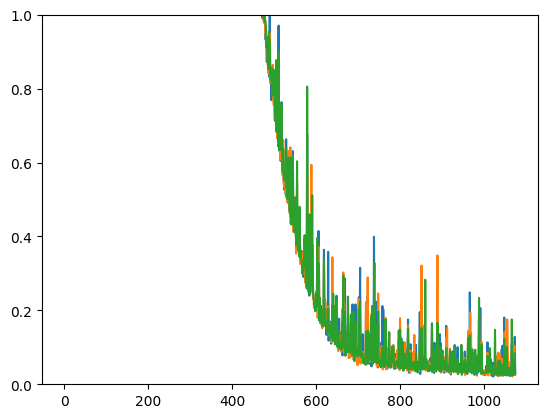

In [ ]:
best_f1 = 0
model_path = "/content/drive/MyDrive/thesis_code/two_layer_checkpoints/main_ck/hdfs_256d_w_pe"

for i in range(3):
    # train_log, trained_center = training_loop()
    # test_log = testing()
    log = train_test()

    current_f1 = matrices.iloc[-1]['f1']

    if current_f1 > best_f1:
        best_f1 = current_f1
        torch.save(model.state_dict(), model_path)

    plt.plot(log['training_loss'], label=f"{i+1}")
    plt.ylim(0, 1)
print(":)")

In [ ]:
matrices

,auc,precision,recall,f1
0,0.913208,0.960051,0.755018,0.845279
1,0.925830,0.955065,0.824267,0.884858
2,0.954829,0.840163,0.977729,0.903741


In [ ]:
matrices.mean()

auc          0.931289
precision    0.918426
recall       0.852338
f1           0.877960
dtype: float64

### Store the results

#### Trained center

In [ ]:
trained_center.shape, trained_center[:3]

(torch.Size([256]),
 tensor([ 0.4677,  0.2089, -0.3343], device='cuda:0', grad_fn=<SliceBackward0>))

In [ ]:
trained_center = trained_center.detach().cpu().numpy()
type(trained_center)

numpy.ndarray

In [ ]:
trained_c_df = pd.DataFrame(trained_center, columns=['trained_c_256d'])
trained_c_df = trained_c_df.T
trained_c_df

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
trained_c_256d,0.467667,0.20889,-0.334266,-0.809113,-1.16,-0.675276,0.55948,0.667437,0.387284,-0.279814,...,0.599598,-0.189542,-0.353587,0.60933,-0.232434,1.232953,-0.293725,1.102076,-0.595703,-0.353368


In [ ]:
trained_c_256_path = "/content/drive/MyDrive/thesis_code/storage/main/hdfs/trained_c_256d.csv"
trained_c_df.to_csv(trained_c_256_path, index=False)
print(f'Trained center 256 dimension saved to {trained_c_256_path}')

Trained center 256 dimension saved to /content/drive/MyDrive/thesis_code/storage/main/hdfs/trained_c_256d.csv


#### Train log

##### Bert output

In [ ]:
train_log.keys()

dict_keys(['training_loss', 'bert_output', 'transformer_output'])

In [ ]:
type(train_log['bert_output']), len(train_log['bert_output'])

(list, 1088886)

In [ ]:
train_bert_output = pd.DataFrame(train_log['bert_output'], columns=[i for i in range(256)])
train_bert_output

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,1.081841,0.059277,0.825416,0.799196,0.788660,-1.135034,-0.880363,0.621473,-2.873982,0.837128,...,0.387932,0.488998,-1.424652,-0.161746,-0.648634,0.894297,-0.111781,-1.153563,-0.431968,0.805209
1,1.015848,-0.090943,-0.295976,-0.158313,0.733618,-1.242472,-0.863827,0.092347,-2.439448,1.391906,...,0.811705,0.174608,-0.930041,-0.449439,-0.939426,1.087927,0.170282,-1.186464,-0.879874,-0.236500
2,0.974014,0.532829,0.088231,1.412835,0.250141,-1.061161,-0.872896,-0.353647,-1.432643,0.785806,...,1.199637,-0.229714,-1.613428,-0.559603,-0.242552,3.485744,-0.038727,-0.233495,-0.321964,-0.128195
3,1.136062,-0.572266,-0.048584,0.943135,-0.209831,-0.838238,-0.894928,-0.198498,-2.931512,1.122966,...,1.058805,0.477938,-1.242359,-0.691184,-0.616764,1.320806,0.204839,-1.263748,-0.318406,-0.532494
4,0.818875,0.210596,-0.472527,0.985816,0.412847,-1.308780,-1.112620,0.543921,-2.289771,0.210074,...,0.307419,-0.793624,-0.306255,0.004379,-0.296765,1.989290,-0.871657,-0.041778,-0.302754,0.533057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088881,1.199122,0.295403,0.368194,1.004387,1.822975,-0.906012,-1.123851,-0.407174,-0.864088,-0.242904,...,-0.092978,0.092847,-0.990358,0.300815,-0.763909,1.610045,-0.954473,0.347797,-0.818985,-1.085564
1088882,1.277479,0.235436,0.401924,0.858130,1.769261,-0.930865,-1.205104,-0.391306,-0.786767,-0.393287,...,-0.155801,0.181074,-1.025912,0.390967,-0.817467,1.558664,-1.025228,0.307876,-0.806065,-1.046382
1088883,1.255898,0.405790,0.140358,1.210579,1.257051,-0.893748,-1.509985,-0.725870,-0.878780,-0.765012,...,-0.143300,0.162517,-1.006710,0.287884,-0.816974,1.643803,-0.918782,0.321965,-0.823747,-1.096607
1088884,1.216791,0.366680,0.071633,0.895979,1.208730,-0.907681,-1.509360,-0.752318,-0.947432,-0.860782,...,-0.143880,0.089262,-0.961464,0.380478,-0.870800,1.588115,-0.795643,0.234149,-0.750994,-1.116308


In [ ]:
train_bert_output_path = "/content/drive/MyDrive/thesis_code/storage/main/train_bert_output.csv"
train_bert_output.to_csv(train_bert_output_path, index=False)

##### Transformer output

In [ ]:
type(train_log['transformer_output']), len(train_log['transformer_output'])

(list, 55822)

In [ ]:
transformer_output_emb_train = train_log['transformer_output']

In [ ]:
train_samples_save = train_samples.copy()
train_samples_save['seq_repr'] = train_log['transformer_output'][-27911:]
train_samples_save

In [ ]:
train_samples_save['index_seq'] = train_samples_save['index_seq'].apply(lambda x: ast.literal_eval(x))

In [ ]:
train_samples_save

In [ ]:
train_samples_w_repr_path = "/content/drive/MyDrive/thesis_code/storage/main/train_samples_transformer_output.csv"
train_samples_save.to_csv(train_samples_w_repr_path, index=False)

#### Testing log

##### Bert output

In [ ]:
len(test_log['bert_output_normal']), len(test_log['bert_output_anomaly'])

(328531, 288250)

In [ ]:
test_bert_output_normal = pd.DataFrame(test_log['bert_output_normal'], columns=[i for i in range(256)])
test_bert_output_anomaly = pd.DataFrame(test_log['bert_output_anomaly'], columns=[i for i in range(256)])

In [ ]:
test_bert_output = pd.concat([test_bert_output_normal, test_bert_output_anomaly], ignore_index=True)

In [ ]:
test_bert_output

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,1.168806,0.398312,0.297838,1.116737,1.486424,-1.053753,-1.249513,-0.531965,-0.843662,-0.487621,...,-0.130438,0.111162,-0.919721,0.299588,-0.794517,1.677943,-0.905984,0.237573,-0.845100,-1.046581
1,1.168806,0.398312,0.297838,1.116737,1.486424,-1.053753,-1.249513,-0.531965,-0.843662,-0.487621,...,-0.130438,0.111162,-0.919721,0.299588,-0.794517,1.677943,-0.905984,0.237573,-0.845100,-1.046581
2,1.168806,0.398312,0.297838,1.116737,1.486424,-1.053753,-1.249513,-0.531965,-0.843662,-0.487621,...,-0.130438,0.111162,-0.919721,0.299588,-0.794517,1.677943,-0.905984,0.237573,-0.845100,-1.046581
3,1.225306,0.399374,0.325445,1.129105,1.546832,-0.982763,-1.245107,-0.495685,-0.843757,-0.451562,...,-0.135040,0.115686,-0.962821,0.283850,-0.778520,1.671156,-0.927021,0.260256,-0.820185,-1.088694
4,1.193411,0.332888,0.405036,0.998068,1.836737,-1.004412,-0.987181,-0.260955,-0.824903,-0.102449,...,-0.131177,0.072448,-0.940615,0.308138,-0.750264,1.658218,-0.909650,0.267970,-0.818723,-1.014878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616776,1.192932,0.310822,0.341779,0.990645,1.753600,-0.955463,-1.081711,-0.438621,-0.808199,-0.273126,...,-0.113467,0.111432,-0.982758,0.314000,-0.815231,1.603852,-0.959599,0.322589,-0.798514,-1.074723
616777,1.192932,0.310822,0.341779,0.990645,1.753600,-0.955463,-1.081711,-0.438621,-0.808199,-0.273126,...,-0.113467,0.111432,-0.982758,0.314000,-0.815231,1.603852,-0.959599,0.322589,-0.798514,-1.074723
616778,1.255146,0.432243,0.158276,1.221004,1.244915,-0.875203,-1.490712,-0.735318,-0.947287,-0.843127,...,-0.136112,0.141548,-0.961886,0.326465,-0.814680,1.584553,-0.903899,0.289762,-0.838695,-1.105887
616779,1.255118,0.431115,0.159382,1.218493,1.248987,-0.876942,-1.487128,-0.734553,-0.946600,-0.841027,...,-0.135807,0.141222,-0.961846,0.326144,-0.814322,1.585439,-0.903581,0.288585,-0.836626,-1.105440


In [ ]:
nor_label, anom_label = [0] * 328531, [1] * 288250
label_list = nor_label + anom_label

test_bert_output['label'] = label_list

In [ ]:
test_bert_output['label']

0         0
1         0
2         0
3         0
4         0
         ..
616776    1
616777    1
616778    1
616779    1
616780    1
Name: label, Length: 616781, dtype: int64

In [ ]:
test_bert_output_path = "/content/drive/MyDrive/thesis_code/storage/main/test_bert_output.csv"
test_bert_output.to_csv(test_bert_output_path, index=False)

##### Transformer output

In [ ]:
test_log.keys()

dict_keys(['score', 'representation'])

In [ ]:
test_samples_save = test_samples.copy()
test_samples_save['seq_repr'] = test_log['representation']
test_samples_save['index_seq'] = test_samples_save['index_seq'].apply(lambda x: ast.literal_eval(x))
test_samples_save

,index_seq,label,seq_repr
30806,"[Receiving block <ID> src <IP> dest <IP>, ...",Normal,"[0.4564555287361145, 0.20415867865085602, -0.3..."
10073,"[Receiving block <ID> src <IP> dest <IP>, ...",Anomaly,"[0.4724333584308624, 0.21457505226135254, -0.3..."
1743,"[Receiving block <ID> src <IP> dest <IP>, ...",Anomaly,"[0.45704689621925354, 0.22131113708019257, -0...."
22026,"[Receiving block <ID> src <IP> dest <IP>, ...",Normal,"[0.455941379070282, 0.20392455160617828, -0.34..."
10267,"[Receiving block <ID> src <IP> dest <IP>, ...",Anomaly,"[0.4723832309246063, 0.21385422348976135, -0.3..."
...,...,...,...
24866,"[Receiving block <ID> src <IP> dest <IP>, ...",Normal,"[0.45683854818344116, 0.22190523147583008, -0...."
12018,"[Receiving block <ID> src <IP> dest <IP>, ...",Anomaly,"[0.45675110816955566, 0.22177720069885254, -0...."
15035,"[Receiving block <ID> src <IP> dest <IP>, ...",Anomaly,"[0.7294991612434387, 0.2164839506149292, 0.059..."
27240,"[Receiving block <ID> src <IP> dest <IP>, ...",Normal,"[0.4586094319820404, 0.20038124918937683, -0.3..."


In [ ]:
test_samples_w_repr_path = "/content/drive/MyDrive/thesis_code/storage/main/hdfs/test_samples_transformer_output.csv"
test_samples_save.to_csv(test_samples_w_repr_path, index=False)

## Plot

In [ ]:
embedding_path = "/content/drive/MyDrive/thesis_code/storage/main/hdfs/test_samples_transformer_output.csv"
df_output = pd.read_csv(embedding_path)
df_output

,index_seq,label,seq_repr
0,['Receiving block <ID> src <IP> dest <IP>'...,Normal,"[0.4564555287361145, 0.20415867865085602, -0.3..."
1,['Receiving block <ID> src <IP> dest <IP>'...,Anomaly,"[0.4724333584308624, 0.21457505226135254, -0.3..."
2,['Receiving block <ID> src <IP> dest <IP>'...,Anomaly,"[0.45704689621925354, 0.22131113708019257, -0...."
3,['Receiving block <ID> src <IP> dest <IP>'...,Normal,"[0.455941379070282, 0.20392455160617828, -0.34..."
4,['Receiving block <ID> src <IP> dest <IP>'...,Anomaly,"[0.4723832309246063, 0.21385422348976135, -0.3..."
...,...,...,...
33671,['Receiving block <ID> src <IP> dest <IP>'...,Normal,"[0.45683854818344116, 0.22190523147583008, -0...."
33672,['Receiving block <ID> src <IP> dest <IP>'...,Anomaly,"[0.45675110816955566, 0.22177720069885254, -0...."
33673,['Receiving block <ID> src <IP> dest <IP>'...,Anomaly,"[0.7294991612434387, 0.2164839506149292, 0.059..."
33674,['Receiving block <ID> src <IP> dest <IP>'...,Normal,"[0.4586094319820404, 0.20038124918937683, -0.3..."


In [ ]:
df_output['seq_repr'] = df_output['seq_repr'].apply(lambda x: json.loads(x))

In [ ]:
x = df_output['seq_repr'].iloc[0]
type(x)

list

In [ ]:
center_path = "/content/drive/MyDrive/thesis_code/storage/main/hdfs/trained_c_256d.csv"
df_center = pd.read_csv(center_path)
df_center

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.467667,0.20889,-0.334266,-0.809113,-1.16,-0.675276,0.55948,0.667437,0.387284,-0.279814,...,0.599598,-0.189542,-0.353587,0.60933,-0.232434,1.232953,-0.293725,1.102076,-0.595703,-0.353368


In [ ]:
trained_center = df_center.iloc[0].to_numpy()
trained_center[:5]

array([ 0.46766737,  0.2088901 , -0.3342658 , -0.809113  , -1.1599998 ])

### PCA 2D

In [ ]:
test_samples

,index_seq,label
30806,['Receiving block <ID> src <IP> dest <IP>'...,Normal
10073,['Receiving block <ID> src <IP> dest <IP>'...,Anomaly
1743,['Receiving block <ID> src <IP> dest <IP>'...,Anomaly
22026,['Receiving block <ID> src <IP> dest <IP>'...,Normal
10267,['Receiving block <ID> src <IP> dest <IP>'...,Anomaly
...,...,...
24866,['Receiving block <ID> src <IP> dest <IP>'...,Normal
12018,['Receiving block <ID> src <IP> dest <IP>'...,Anomaly
15035,['Receiving block <ID> src <IP> dest <IP>'...,Anomaly
27240,['Receiving block <ID> src <IP> dest <IP>'...,Normal


In [ ]:
test_samples_draw = test_samples.copy()
# test_samples_draw['proj'] = [np.array(li) for li in test_log['representation']]
test_samples_draw['proj'] = [np.array(li) for li in df_output['seq_repr']]
pca = PCA(n_components=2)
reduced_pca = pca.fit_transform(np.stack(test_samples_draw.proj))
print("Explained ratio: ", pca.explained_variance_ratio_)

Explained ratio:  [0.84581597 0.08485765]


In [ ]:
reduced_pca.shape

(33676, 2)

In [ ]:
colors = test_samples_draw['label'].apply(lambda s: "red" if s == "Anomaly" else "blue")

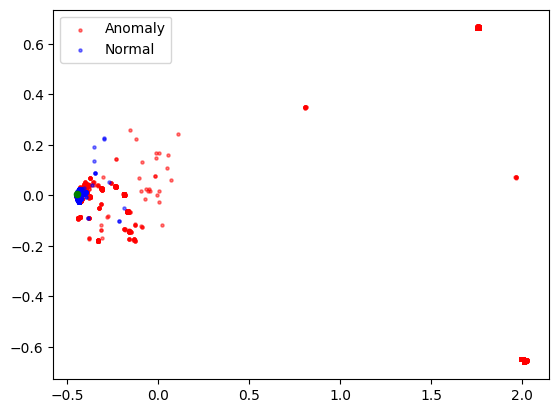

In [ ]:
for label in ['Anomaly', 'Normal']:
    x = pca.transform(np.stack(test_samples_draw[test_samples_draw.label==label].proj.to_numpy()))
    plt.scatter(x[:, 0], x[:, 1], s=5, c='red' if label=='Anomaly' else 'blue',
                    alpha=0.5, label=label)
c = pca.transform([trained_center])
plt.scatter(c[:,0], c[:,1], s=20, c='green', zorder=20)
plt.legend()

In [ ]:
"""
plt.scatter(reduced_pca[:, 0], reduced_pca[:, 1], s=5, c=colors)
c = pca.transform([trained_center])
plt.scatter(c[:,0], c[:,1], s=20, c='green', zorder=20)
"""

"\nplt.scatter(reduced_pca[:, 0], reduced_pca[:, 1], s=5, c=colors)\nc = pca.transform([trained_center])\nplt.scatter(c[:,0], c[:,1], s=20, c='green', zorder=20)\n"

### PCA 3D

In [ ]:
import plotly.graph_objects as go

In [ ]:
test_samples_draw = test_samples.copy()
# test_samples_draw['proj'] = [np.array(li) for li in test_log['representation']]
test_samples_draw['proj'] = [np.array(li) for li in df_output['seq_repr']]
pca = PCA(n_components=3)
# reduced_pca = pca.fit_transform(np.stack(test_samples_draw.proj.to_numpy()))
reduced_pca = pca.fit_transform(np.stack(test_samples_draw.proj))
print("Explained ratio: ", pca.explained_variance_ratio_)

Explained ratio:  [0.8769019  0.07852886 0.02993403]


In [ ]:
reduced_ = reduced_pca

fig = go.Figure(
    data = [
        go.Scatter3d(
            x = reduced_[:, 0],
            y = reduced_[:, 1],
            z = reduced_[:, 2],
            mode = "markers",
            marker = dict(
                colorscale = "Viridis",
                color = colors,
                opacity = 0.8,
                size = 2,
            ),
        )
    ]
)
fig.show()

### Test bert output

In [ ]:
test_bert_output_df = pd.read_csv("/content/drive/MyDrive/thesis_code/storage/main/hdfs/test_bert_output.csv")
test_bert_output_df.head()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,label
0,1.168806,0.398312,0.297838,1.116737,1.486424,-1.053753,-1.249513,-0.531965,-0.843662,-0.487621,...,0.111162,-0.919721,0.299588,-0.794517,1.677943,-0.905984,0.237573,-0.845100,-1.046581,0
1,1.168806,0.398312,0.297838,1.116737,1.486424,-1.053753,-1.249513,-0.531965,-0.843662,-0.487621,...,0.111162,-0.919721,0.299588,-0.794517,1.677943,-0.905984,0.237573,-0.845100,-1.046581,0
2,1.168806,0.398312,0.297838,1.116737,1.486424,-1.053753,-1.249513,-0.531965,-0.843662,-0.487621,...,0.111162,-0.919721,0.299588,-0.794517,1.677943,-0.905984,0.237573,-0.845100,-1.046581,0
3,1.225306,0.399374,0.325445,1.129105,1.546832,-0.982763,-1.245107,-0.495685,-0.843757,-0.451562,...,0.115686,-0.962821,0.283850,-0.778520,1.671156,-0.927021,0.260256,-0.820185,-1.088694,0
4,1.193411,0.332888,0.405036,0.998068,1.836737,-1.004412,-0.987181,-0.260955,-0.824903,-0.102449,...,0.072448,-0.940615,0.308138,-0.750264,1.658218,-0.909650,0.267970,-0.818723,-1.014878,0


In [ ]:
test_bert_output_df['bert_repr'] = test_bert_output_df[test_bert_output_df.columns[:-2]].values.tolist()
test_df = test_bert_output_df.copy()

In [ ]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,248,249,250,251,252,253,254,255,label,bert_repr
0,1.168806,0.398312,0.297838,1.116737,1.486424,-1.053753,-1.249513,-0.531965,-0.843662,-0.487621,...,-0.919721,0.299588,-0.794517,1.677943,-0.905984,0.237573,-0.845100,-1.046581,0,"[1.1688063144683838, 0.3983120024204254, 0.297..."
1,1.168806,0.398312,0.297838,1.116737,1.486424,-1.053753,-1.249513,-0.531965,-0.843662,-0.487621,...,-0.919721,0.299588,-0.794517,1.677943,-0.905984,0.237573,-0.845100,-1.046581,0,"[1.1688063144683838, 0.3983120024204254, 0.297..."
2,1.168806,0.398312,0.297838,1.116737,1.486424,-1.053753,-1.249513,-0.531965,-0.843662,-0.487621,...,-0.919721,0.299588,-0.794517,1.677943,-0.905984,0.237573,-0.845100,-1.046581,0,"[1.1688063144683838, 0.3983120024204254, 0.297..."
3,1.225306,0.399374,0.325445,1.129105,1.546832,-0.982763,-1.245107,-0.495685,-0.843757,-0.451562,...,-0.962821,0.283850,-0.778520,1.671156,-0.927021,0.260256,-0.820185,-1.088694,0,"[1.2253057956695557, 0.3993737399578094, 0.325..."
4,1.193411,0.332888,0.405036,0.998068,1.836737,-1.004412,-0.987181,-0.260955,-0.824903,-0.102449,...,-0.940615,0.308138,-0.750264,1.658218,-0.909650,0.267970,-0.818723,-1.014878,0,"[1.1934105157852173, 0.3328878581523895, 0.405..."


In [ ]:
test_df = test_df.drop([i for i in range(256)], axis=1)
test_df.head()

In [ ]:
test_bert_repr_path = "/content/drive/MyDrive/thesis_code/storage/main/hdfs/test_bert_reprs.csv"
test_df.to_csv(test_bert_repr_path, index=False)

Starting drawing with PCA...
Explained ratio:  [0.64079452 0.33938752]


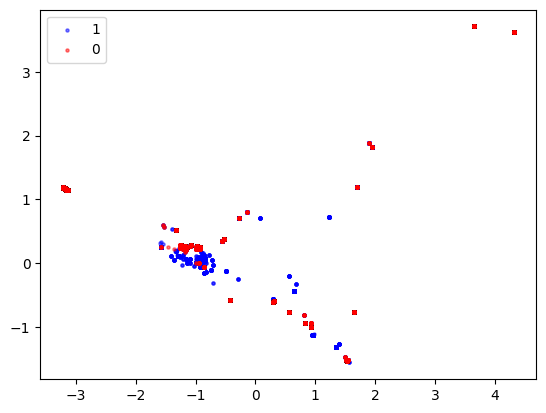

In [ ]:
print(f"Starting drawing with PCA...")
test_df['proj'] = [np.array(li) for li in test_df['bert_repr']]
pca = PCA(n_components=2)
pca.fit(np.stack(test_df.proj.to_numpy()))
print("Explained ratio: ", pca.explained_variance_ratio_)
for label in [1, 0]:
    x = pca.transform(np.stack(test_df[test_df.label==label].proj.to_numpy()))
    plt.scatter(x[:, 0], x[:, 1], s=5, c='red' if label==0 else 'blue',
                    alpha=0.5, label=label)
# c = pca.transform([trained_center])
# plt.scatter(c[:,0], c[:,1], s=40, c='green', zorder=20)
plt.legend()

### UMAP

In [ ]:
!pip install umap-learn
!pip install umap-learn[plot]

In [ ]:
!pip install plotly

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
import plotly.express as px

In [ ]:
umap_x = df_output['seq_repr']
umap_y = df_output['label'].apply(lambda x: 0 if x=='Normal' else 1)

In [ ]:
umap_x

0        [-0.7393079996109009, -0.2955278754234314, 0.1...
1        [-0.7297504544258118, -0.276479572057724, 0.20...
2        [-0.7388650178909302, -0.28313836455345154, 0....
3        [-0.7395408153533936, -0.2954743802547455, 0.1...
4        [-0.7293911576271057, -0.27626025676727295, 0....
                               ...                        
33671    [-0.7382559776306152, -0.28395774960517883, 0....
33672    [-0.7387725114822388, -0.2829768657684326, 0.1...
33673    [-0.36072346568107605, -0.30334675312042236, 0...
33674    [-0.7350758910179138, -0.29816219210624695, 0....
33675    [-0.5047743320465088, -0.2873150706291199, 0.0...
Name: seq_repr, Length: 33676, dtype: object

In [ ]:
umap_x_array = np.stack(umap_x.values)
umap_x_array

array([[-0.739308  , -0.29552788,  0.19040023, ...,  0.38665935,
         0.80143982,  1.25373745],
       [-0.72975045, -0.27647957,  0.20195754, ...,  0.36646053,
         0.78848797,  1.25359428],
       [-0.73886502, -0.28313836,  0.18500234, ...,  0.38459861,
         0.79873139,  1.25381386],
       ...,
       [-0.36072347, -0.30334675,  0.29456034, ...,  0.29278344,
         0.86549109,  1.38303924],
       [-0.73507589, -0.29816219,  0.19115995, ...,  0.37791219,
         0.7994231 ,  1.2544663 ],
       [-0.50477433, -0.28731507,  0.07665576, ...,  0.35779721,
         0.77005243,  1.25363851]])

In [ ]:
umap_y

0        0
1        1
2        1
3        0
4        1
        ..
33671    0
33672    1
33673    1
33674    0
33675    1
Name: label, Length: 33676, dtype: int64

In [ ]:
reducer = umap.UMAP(n_components=3)
embeddings = reducer.fit_transform(umap_x_array)

In [ ]:
marker_size = 5

fig = px.scatter_3d(
    x=embeddings[:, 0], y=embeddings[:, 1], z=embeddings[:, 2],
    color=umap_y, labels={'color': 'label'},
)
fig.update_layout(title='3D UMAP projection', margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
reducer_2d = umap.UMAP(n_components=2)
embeddings = reducer_2d.fit_transform(umap_x_array)

In [ ]:
marker_size = 5

fig = px.scatter(
    x=embeddings[:, 0], y=embeddings[:, 1],
    color=umap_y, labels={'color': 'label'},
)
fig.update_layout(title='2D UMAP projection', margin=dict(l=0, r=0, b=0, t=0))
fig.show()